# Load CrossLayer Transcoder from Checkpoint

This notebook demonstrates how to load a saved CrossLayerTranscoderModule from a Lightning checkpoint and explore the model.


In [1]:
import torch
import torch.nn as nn
import lightning as L
from pathlib import Path
import numpy as np
from model.clt_lightning import CrossLayerTranscoderModule
from model.clt import CrossLayerTranscoder
from model.standardize import DimensionwiseInputStandardizer, DimensionwiseOutputStandardizer
import matplotlib.pyplot as plt

/var/metrics/g/crosslayer-transcoder/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os

# Add current directory to Python path
sys.path.append(os.getcwd())

print("Python path:")
for path in sys.path:
    print(f"  {path}")


Python path:
  /var/metrics/g/py312/lib/python312.zip
  /var/metrics/g/py312/lib/python3.12
  /var/metrics/g/py312/lib/python3.12/lib-dynload
  
  /var/metrics/g/crosslayer-transcoder/.venv/lib/python3.12/site-packages
  /tmp/tmpj_o0wenf
  /var/metrics/g/crosslayer-transcoder


## Load the Checkpoint

Load the saved CrossLayerTranscoderModule from the Lightning checkpoint.


In [3]:
# Path to the checkpoint
checkpoint_path = "checkpoints/clt.ckpt"
model = CrossLayerTranscoderModule.load_from_checkpoint(
    checkpoint_path,
    map_location="cuda:0"  # Load to GPU 1
)
        
model.eval()


Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1561 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2459 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2027 > 1024). Running this sequence through the model will result in indexing errors


Compiling model


CrossLayerTranscoderModule(
  (model): CrossLayerTranscoder(
    (nonlinearity): JumpReLU()
    (input_standardizer): DimensionwiseInputStandardizer()
    (output_standardizer): DimensionwiseOutputStandardizer()
  )
  (replacement_model): ReplacementModelAccuracy(
    (replacement_model): ReplacementModel()
  )
)

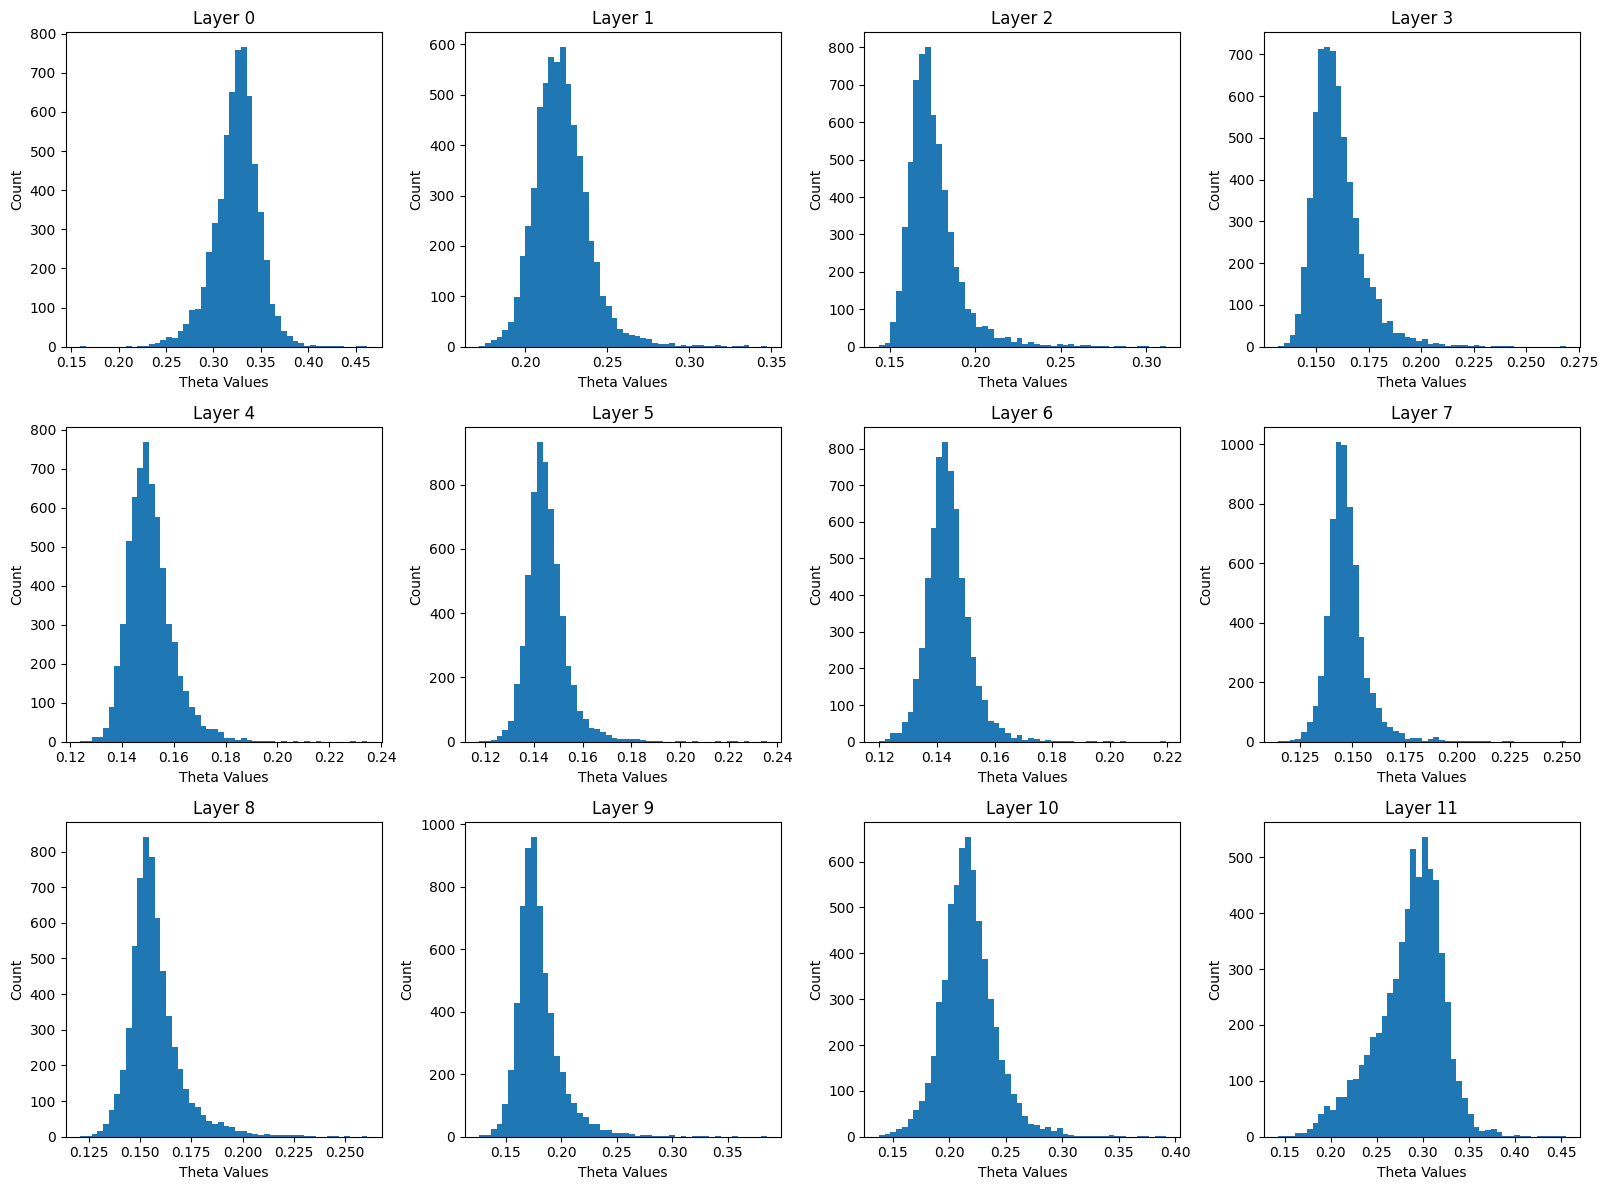

In [10]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Plot histogram for each layer
thetas = model.model.nonlinearity.theta[0]
for layer in range(12):
    ax = axes[layer]
    ax.hist(thetas[layer].cpu().detach().numpy(), bins=50)
    ax.set_title(f'Layer {layer}')
    ax.set_xlabel('Theta Values')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [4]:
# Load checkpoint directly to examine contents
import torch

ckpt = torch.load("checkpoints/clt.ckpt")
print("=== Checkpoint Keys ===")
for key in ckpt.keys():
    print(key)
    
print("\n=== State Dict Keys ===")
for key in ckpt['state_dict'].keys():
    print(key)


=== Checkpoint Keys ===
epoch
global_step
pytorch-lightning_version
state_dict
loops
callbacks
optimizer_states
lr_schedulers
MixedPrecision
hparams_name
hyper_parameters
datamodule_hparams_name
datamodule_hyper_parameters

=== State Dict Keys ===
model.W_enc
model.W_dec
model.mask
model.nonlinearity.theta
model.nonlinearity.bandwidth
model.input_standardizer.mean
model.input_standardizer.std
model.output_standardizer.mean
model.output_standardizer.std


In [5]:
ckpt["hyper_parameters"]

{'_class_path': 'model.CrossLayerTranscoderModule',
 'd_acts': 768,
 'd_features': 6144,
 'n_layers': 12,
 'nonlinearity_theta': 0.03,
 'nonlinearity_bandwidth': 1.0,
 'activation_dim': 768,
 'lambda_sparsity': 0.0004,
 'c_sparsity': 0.1,
 'learning_rate': 0.001,
 'replacement_model_accuracy': {'class_path': 'metrics.ReplacementModelAccuracy',
  'init_args': {'model_name': 'openai-community/gpt2',
   'device_map': 'cuda:0',
   'loader_batch_size': 5}},
 'compile': True,
 '_instantiator': 'lightning.pytorch.cli.instantiate_module'}

In [ ]:
if model is not None:
    print("=== Model Hyperparameters ===")
    for key, value in model.hparams.items():
        print(f"{key}: {value}")
    
    print("\n=== Core Model Architecture ===")
    core_model = model.model
    print(f"Model type: {type(core_model)}")
    
    if hasattr(core_model, 'n_layers'):
        print(f"Number of layers: {core_model.n_layers}")
    if hasattr(core_model, 'd_acts'):
        print(f"Activation dimension: {core_model.d_acts}")
    if hasattr(core_model, 'd_features'):
        print(f"Feature dimension: {core_model.d_features}")
    
    print("\n=== Model Parameters ===")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    print("\n=== Core Model Components ===")
    for name, module in core_model.named_children():
        if hasattr(module, 'shape'):
            print(f"{name}: {module.shape}")
        else:
            print(f"{name}: {type(module).__name__}")


In [ ]:
if model is not None:
    core_model = model.model
    
    # Check for encoder weights
    if hasattr(core_model, 'W_enc'):
        W_enc = core_model.W_enc
        print(f"Encoder weights shape: {W_enc.shape}")
        print(f"Encoder weights dtype: {W_enc.dtype}")
        print(f"Encoder weights device: {W_enc.device}")
        print(f"Encoder weights range: [{W_enc.min():.6f}, {W_enc.max():.6f}]")
    
    # Check for decoder weights
    if hasattr(core_model, 'W_dec'):
        W_dec = core_model.W_dec
        print(f"\nDecoder weights shape: {W_dec.shape}")
        print(f"Decoder weights dtype: {W_dec.dtype}")
        print(f"Decoder weights device: {W_dec.device}")
        print(f"Decoder weights range: [{W_dec.min():.6f}, {W_dec.max():.6f}]")
    
    # Check for mask
    if hasattr(core_model, 'mask'):
        mask = core_model.mask
        print(f"\nMask shape: {mask.shape}")
        print(f"Mask dtype: {mask.dtype}")
        print(f"Mask non-zero elements: {mask.sum().item()} / {mask.numel()} ({100*mask.sum().item()/mask.numel():.1f}%)")
    
    # Check bias
    if hasattr(core_model, 'b_dec'):
        b_dec = core_model.b_dec
        print(f"\nDecoder bias shape: {b_dec.shape}")
        print(f"Decoder bias range: [{b_dec.min():.6f}, {b_dec.max():.6f}]")


In [ ]:
if model is not None and hasattr(model.model, 'mask'):
    mask = model.model.mask.detach().cpu().numpy()
    
    # Plot the mask structure
    plt.figure(figsize=(10, 8))
    plt.imshow(mask, cmap='Blues', aspect='auto')
    plt.title('CrossLayer Transcoder Mask Structure')
    plt.xlabel('To Layer')
    plt.ylabel('From Layer')
    plt.colorbar(label='Mask Value')
    plt.tight_layout()
    plt.show()
    
    # Show mask statistics per layer
    mask_sum_per_layer = mask.sum(axis=1)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(mask_sum_per_layer)), mask_sum_per_layer)
    plt.title('Number of Active Connections per Layer')
    plt.xlabel('Layer')
    plt.ylabel('Number of Active Connections')
    plt.tight_layout()
    plt.show()


In [ ]:
if model is not None:
    # Create dummy input data
    batch_size = 4
    
    # Get model dimensions
    if hasattr(model.model, 'n_layers') and hasattr(model.model, 'd_acts'):
        n_layers = model.model.n_layers
        d_acts = model.model.d_acts
        
        print(f"Creating dummy input with shape: ({batch_size}, {n_layers}, {d_acts})")
        
        # Create normalized random input
        dummy_input = torch.randn(batch_size, n_layers, d_acts)
        
        # Run forward pass
        with torch.no_grad():
            try:
                features, reconstructions = model(dummy_input)
                
                print(f"\n=== Forward Pass Results ===")
                print(f"Input shape: {dummy_input.shape}")
                print(f"Features shape: {features.shape}")
                print(f"Reconstructions shape: {reconstructions.shape}")
                
                # Compute reconstruction error
                if hasattr(model.model, 'output_standardizer'):
                    # If we have standardizers, we need to handle normalization
                    print("\nNote: Model uses standardizers - reconstruction comparison may not be direct")
                else:
                    mse = torch.mean((dummy_input - reconstructions)**2)
                    print(f"\nReconstruction MSE: {mse.item():.6f}")
                
                # Feature statistics
                print(f"\n=== Feature Statistics ===")
                print(f"Features mean: {features.mean().item():.6f}")
                print(f"Features std: {features.std().item():.6f}")
                print(f"Features sparsity (% zeros): {100 * (features == 0).float().mean().item():.1f}%")
                print(f"Features L0 norm (avg active per sample): {(features > 0).float().sum(dim=[1,2]).mean().item():.1f}")
                
            except Exception as e:
                print(f"❌ Error during forward pass: {e}")
                print("The model may need initialization or specific input formatting.")
    else:
        print("Could not determine model dimensions for demo.")


In [ ]:
if model is not None:
    core_model = model.model
    
    print("=== Available Model Components ===")
    
    # Core transcoder
    print(f"Core transcoder: {type(core_model)}")
    
    # Standardizers
    if hasattr(core_model, 'input_standardizer'):
        print(f"Input standardizer: {type(core_model.input_standardizer)}")
        if hasattr(core_model.input_standardizer, 'is_initialized'):
            print(f"  - Initialized: {core_model.input_standardizer.is_initialized}")
    
    if hasattr(core_model, 'output_standardizer'):
        print(f"Output standardizer: {type(core_model.output_standardizer)}")
        if hasattr(core_model.output_standardizer, 'is_initialized'):
            print(f"  - Initialized: {core_model.output_standardizer.is_initialized}")
    
    # Activation function
    if hasattr(core_model, 'activation'):
        print(f"Activation function: {type(core_model.activation)}")
        if hasattr(core_model.activation, 'threshold'):
            print(f"  - Threshold shape: {core_model.activation.threshold.shape}")
            print(f"  - Threshold range: [{core_model.activation.threshold.min():.6f}, {core_model.activation.threshold.max():.6f}]")
    
    print("\n=== Training Configuration ===")
    print(f"Lambda sparsity: {model._lambda}")
    print(f"C sparsity: {model.c}")
    print(f"Learning rate: {model.learning_rate}")
    print(f"Compile mode: {model.compile}")
    
    print("\n=== Model State ===")
    print(f"Training: {model.training}")
    print(f"Device: {next(model.parameters()).device}")
    print(f"Dtype: {next(model.parameters()).dtype}")

print("\nModel loading and exploration complete!")
